In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 특정 GPU에 1GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6000)])
    except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
        print(e)
        
print('GPU ready')


GPU ready


In [7]:
# 사진별로 번호 멕이기

#csv
import pandas as pd

category_csv = pd.read_csv('../data/category.csv')
label_dict = dict(category_csv[['bottle_name', 'bottle_id']].values)
print(label_dict)



# glass_category = {'colorless_bottle': 7, 'glass': 5, 'soju': 0, 'vita': 4, 'colorless_soju': 6, 'crystal': 9, 'soda': 1, 'wine': 3, 'beer': 2, 'color_bottle': 8}

{'ban': 0, 'be': 1, 'beer': 2, 'bottle': 3, 'dish': 4, 'glass': 5, 'me': 6, 'soju': 7, 'trash': 8, 'vita': 9, 'wine': 10}


In [13]:
#이미지 불러오기
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

rootPath = '../data/image/'

with tf.device('/device:GPU:0'):

    train_imageGenerator = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
#         zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=.2
    )
    
    val_imageGenerator = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2
    )
    # 이미지 불러옴
    trainGen = train_imageGenerator.flow_from_directory(
        rootPath,
        target_size=(224, 224),
        classes=label_dict,
        subset='training',
        batch_size = 50,
        class_mode="sparse"
    )

    validationGen = val_imageGenerator.flow_from_directory(
        rootPath,
        target_size=(224, 224),
        classes=label_dict,
        subset='validation',
        batch_size = 10,
        class_mode="sparse"
    )

Found 192 images belonging to 11 classes.
Found 41 images belonging to 11 classes.


In [14]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential

with tf.device('/device:GPU:0'):

    VGG16_model_base = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(224,224,3))
    VGG16_model_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [28]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from tensorflow.keras.applications import DenseNet201
# from tensorflow.keras.layers import GlobalAveragePooling2D
# from tensorflow_addons.optimizers import RectifiedAdam
# from tensorflow.keras.optimizers import Adam,SGD


with tf.device('/device:GPU:0'):

    VGG16_model_base = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(224,224,3))

    VGG16_model_base.trainable = False  # Convolution Layer 동결

    model = Sequential()
    model.add(VGG16_model_base)
    
    model.add(Flatten(input_shape=(7*7*512,)))
    model.add(Dense(11,
                    activation='softmax'))

    model.summary()

    model.compile(optimizer=RMSprop(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    
    # adjust learning rate
#     def get_lr_callback():
#         lr_start   = 0.000001*10*0.5
#         lr_max     = 0.0000005 * 12 * 10*0.5
#         lr_min     = 0.000001 * 10*0.5
#         lr_ramp_ep = 5
#         lr_sus_ep  = 0
#         lr_decay   = 0.8


#         def lrfn(epoch):
#             if epoch < lr_ramp_ep:
#                 lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start   
#             elif epoch < lr_ramp_ep + lr_sus_ep:
#                 lr = lr_max    
#             else:
#                 lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min    
#             return lr

#         lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = False)
#         return lr_callback
    
    
    # Model saving callback
    checkpointer = ModelCheckpoint(filepath='../model/recycle_vgg16_1205.h5', monitor='val_loss', verbose=1, save_best_only=True)

#     Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=20)

    epochs = 300
    history = model.fit_generator(
        trainGen, 
        epochs=epochs,
        callbacks=[checkpointer, early_stopping],
        steps_per_epoch=2, 
        validation_data=validationGen,
        validation_steps=2,
        verbose=1
    )

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_11 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 11)                275979    
Total params: 14,990,667
Trainable params: 275,979
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/300
2/2 [==============================] - 1s 283ms/step - loss: 1.9711 - sparse_categorical_accuracy: 0.4000

Epoch 00001: val_loss improved from inf to 1.97114, saving model to ../model/recycle_vgg16_1205.h5
2/2 [==============================] - 3s 2s/step - loss: 2.3212 - sparse_categorical_accuracy: 0.1304 - val_loss: 1.9711 - val_sparse_categorical_

2/2 [==============================] - 0s 75ms/step - loss: 1.3749 - sparse_categorical_accuracy: 0.6000

Epoch 00016: val_loss improved from 1.41857 to 1.37491, saving model to ../model/recycle_vgg16_1205.h5
2/2 [==============================] - 1s 736ms/step - loss: 1.6226 - sparse_categorical_accuracy: 0.5200 - val_loss: 1.3749 - val_sparse_categorical_accuracy: 0.6000
Epoch 17/300
2/2 [==============================] - 0s 78ms/step - loss: 1.4269 - sparse_categorical_accuracy: 0.5500

Epoch 00017: val_loss did not improve from 1.37491
2/2 [==============================] - 1s 585ms/step - loss: 1.4811 - sparse_categorical_accuracy: 0.4348 - val_loss: 1.4269 - val_sparse_categorical_accuracy: 0.5500
Epoch 18/300
2/2 [==============================] - 0s 77ms/step - loss: 1.3136 - sparse_categorical_accuracy: 0.6000

Epoch 00018: val_loss improved from 1.37491 to 1.31359, saving model to ../model/recycle_vgg16_1205.h5
2/2 [==============================] - 2s 756ms/step - loss: 1.41

Epoch 34/300
2/2 [==============================] - 0s 80ms/step - loss: 1.0990 - sparse_categorical_accuracy: 0.4500

Epoch 00034: val_loss did not improve from 1.07586
2/2 [==============================] - 1s 708ms/step - loss: 1.2190 - sparse_categorical_accuracy: 0.5800 - val_loss: 1.0990 - val_sparse_categorical_accuracy: 0.4500
Epoch 35/300
2/2 [==============================] - 0s 99ms/step - loss: 1.0869 - sparse_categorical_accuracy: 0.6000

Epoch 00035: val_loss did not improve from 1.07586
2/2 [==============================] - 1s 708ms/step - loss: 1.1712 - sparse_categorical_accuracy: 0.5700 - val_loss: 1.0869 - val_sparse_categorical_accuracy: 0.6000
Epoch 36/300
2/2 [==============================] - 0s 81ms/step - loss: 1.0527 - sparse_categorical_accuracy: 0.5000

Epoch 00036: val_loss improved from 1.07586 to 1.05268, saving model to ../model/recycle_vgg16_1205.h5
2/2 [==============================] - 1s 713ms/step - loss: 1.1898 - sparse_categorical_accuracy: 0.489

2/2 [==============================] - 0s 78ms/step - loss: 0.9118 - sparse_categorical_accuracy: 0.7000

Epoch 00051: val_loss did not improve from 0.89758
2/2 [==============================] - 1s 744ms/step - loss: 0.9619 - sparse_categorical_accuracy: 0.7000 - val_loss: 0.9118 - val_sparse_categorical_accuracy: 0.7000
Epoch 52/300
2/2 [==============================] - 0s 80ms/step - loss: 0.9184 - sparse_categorical_accuracy: 0.6500

Epoch 00052: val_loss did not improve from 0.89758
2/2 [==============================] - 1s 590ms/step - loss: 1.0466 - sparse_categorical_accuracy: 0.5978 - val_loss: 0.9184 - val_sparse_categorical_accuracy: 0.6500
Epoch 53/300
2/2 [==============================] - 0s 92ms/step - loss: 0.8872 - sparse_categorical_accuracy: 0.7000

Epoch 00053: val_loss improved from 0.89758 to 0.88715, saving model to ../model/recycle_vgg16_1205.h5
2/2 [==============================] - 2s 755ms/step - loss: 1.0169 - sparse_categorical_accuracy: 0.6630 - val_loss:

Epoch 69/300
2/2 [==============================] - 0s 84ms/step - loss: 0.7952 - sparse_categorical_accuracy: 0.7000

Epoch 00069: val_loss improved from 0.79638 to 0.79519, saving model to ../model/recycle_vgg16_1205.h5
2/2 [==============================] - 1s 706ms/step - loss: 0.7447 - sparse_categorical_accuracy: 0.8261 - val_loss: 0.7952 - val_sparse_categorical_accuracy: 0.7000
Epoch 70/300
2/2 [==============================] - 0s 82ms/step - loss: 0.8323 - sparse_categorical_accuracy: 0.6500

Epoch 00070: val_loss did not improve from 0.79519
2/2 [==============================] - 1s 703ms/step - loss: 0.8408 - sparse_categorical_accuracy: 0.7300 - val_loss: 0.8323 - val_sparse_categorical_accuracy: 0.6500
Epoch 71/300
2/2 [==============================] - 0s 88ms/step - loss: 0.8480 - sparse_categorical_accuracy: 0.6000

Epoch 00071: val_loss did not improve from 0.79519
2/2 [==============================] - 1s 622ms/step - loss: 0.7789 - sparse_categorical_accuracy: 0.782

Epoch 87/300
2/2 [==============================] - 0s 87ms/step - loss: 0.7743 - sparse_categorical_accuracy: 0.7000

Epoch 00087: val_loss did not improve from 0.72678
2/2 [==============================] - 1s 735ms/step - loss: 0.7529 - sparse_categorical_accuracy: 0.7500 - val_loss: 0.7743 - val_sparse_categorical_accuracy: 0.7000
Epoch 88/300
2/2 [==============================] - 0s 82ms/step - loss: 0.7350 - sparse_categorical_accuracy: 0.7000

Epoch 00088: val_loss did not improve from 0.72678
2/2 [==============================] - 1s 626ms/step - loss: 0.6933 - sparse_categorical_accuracy: 0.8370 - val_loss: 0.7350 - val_sparse_categorical_accuracy: 0.7000
Epoch 89/300
2/2 [==============================] - 0s 85ms/step - loss: 0.7409 - sparse_categorical_accuracy: 0.6500

Epoch 00089: val_loss did not improve from 0.72678
2/2 [==============================] - 1s 652ms/step - loss: 0.6575 - sparse_categorical_accuracy: 0.8152 - val_loss: 0.7409 - val_sparse_categorical_accura

Epoch 105/300
2/2 [==============================] - 0s 96ms/step - loss: 0.6940 - sparse_categorical_accuracy: 0.8000

Epoch 00105: val_loss did not improve from 0.68739
2/2 [==============================] - 1s 659ms/step - loss: 0.6390 - sparse_categorical_accuracy: 0.8370 - val_loss: 0.6940 - val_sparse_categorical_accuracy: 0.8000
Epoch 106/300
2/2 [==============================] - 0s 83ms/step - loss: 0.7372 - sparse_categorical_accuracy: 0.8000

Epoch 00106: val_loss did not improve from 0.68739
2/2 [==============================] - 1s 705ms/step - loss: 0.5665 - sparse_categorical_accuracy: 0.8400 - val_loss: 0.7372 - val_sparse_categorical_accuracy: 0.8000
Epoch 107/300
2/2 [==============================] - 0s 83ms/step - loss: 0.7007 - sparse_categorical_accuracy: 0.8000

Epoch 00107: val_loss did not improve from 0.68739
2/2 [==============================] - 1s 707ms/step - loss: 0.6008 - sparse_categorical_accuracy: 0.8800 - val_loss: 0.7007 - val_sparse_categorical_acc

2/2 [==============================] - 0s 84ms/step - loss: 0.6958 - sparse_categorical_accuracy: 0.8000

Epoch 00123: val_loss did not improve from 0.63338
2/2 [==============================] - 1s 706ms/step - loss: 0.5425 - sparse_categorical_accuracy: 0.9100 - val_loss: 0.6958 - val_sparse_categorical_accuracy: 0.8000
Epoch 124/300
2/2 [==============================] - 0s 85ms/step - loss: 0.6425 - sparse_categorical_accuracy: 0.8000

Epoch 00124: val_loss did not improve from 0.63338
2/2 [==============================] - 1s 586ms/step - loss: 0.5197 - sparse_categorical_accuracy: 0.9022 - val_loss: 0.6425 - val_sparse_categorical_accuracy: 0.8000
Epoch 125/300
2/2 [==============================] - 0s 80ms/step - loss: 0.6586 - sparse_categorical_accuracy: 0.7500

Epoch 00125: val_loss did not improve from 0.63338
2/2 [==============================] - 1s 615ms/step - loss: 0.5860 - sparse_categorical_accuracy: 0.8370 - val_loss: 0.6586 - val_sparse_categorical_accuracy: 0.7500


2/2 [==============================] - 0s 86ms/step - loss: 0.6157 - sparse_categorical_accuracy: 0.8500

Epoch 00141: val_loss did not improve from 0.58188
2/2 [==============================] - 1s 703ms/step - loss: 0.4969 - sparse_categorical_accuracy: 0.8700 - val_loss: 0.6157 - val_sparse_categorical_accuracy: 0.8500
Epoch 142/300
2/2 [==============================] - 0s 83ms/step - loss: 0.6258 - sparse_categorical_accuracy: 0.8000

Epoch 00142: val_loss did not improve from 0.58188
2/2 [==============================] - 1s 596ms/step - loss: 0.4834 - sparse_categorical_accuracy: 0.8804 - val_loss: 0.6258 - val_sparse_categorical_accuracy: 0.8000
Epoch 143/300
2/2 [==============================] - 0s 86ms/step - loss: 0.6390 - sparse_categorical_accuracy: 0.8000

Epoch 00143: val_loss did not improve from 0.58188
2/2 [==============================] - 1s 645ms/step - loss: 0.4674 - sparse_categorical_accuracy: 0.8696 - val_loss: 0.6390 - val_sparse_categorical_accuracy: 0.8000


2/2 [==============================] - 0s 84ms/step - loss: 0.6055 - sparse_categorical_accuracy: 0.8000

Epoch 00159: val_loss did not improve from 0.55871
2/2 [==============================] - 1s 671ms/step - loss: 0.4679 - sparse_categorical_accuracy: 0.8804 - val_loss: 0.6055 - val_sparse_categorical_accuracy: 0.8000
Epoch 160/300
2/2 [==============================] - 0s 84ms/step - loss: 0.6333 - sparse_categorical_accuracy: 0.8000

Epoch 00160: val_loss did not improve from 0.55871
2/2 [==============================] - 1s 656ms/step - loss: 0.4262 - sparse_categorical_accuracy: 0.9200 - val_loss: 0.6333 - val_sparse_categorical_accuracy: 0.8000
Epoch 161/300
2/2 [==============================] - 0s 86ms/step - loss: 0.6973 - sparse_categorical_accuracy: 0.8000

Epoch 00161: val_loss did not improve from 0.55871
2/2 [==============================] - 1s 621ms/step - loss: 0.4197 - sparse_categorical_accuracy: 0.9348 - val_loss: 0.6973 - val_sparse_categorical_accuracy: 0.8000


2/2 [==============================] - 0s 83ms/step - loss: 0.6304 - sparse_categorical_accuracy: 0.8000

Epoch 00177: val_loss did not improve from 0.55871
2/2 [==============================] - 1s 665ms/step - loss: 0.3833 - sparse_categorical_accuracy: 0.9700 - val_loss: 0.6304 - val_sparse_categorical_accuracy: 0.8000
Epoch 00177: early stopping


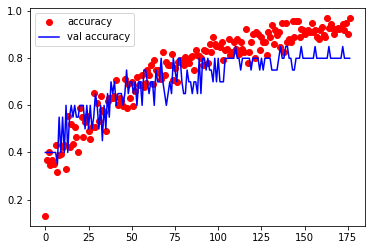

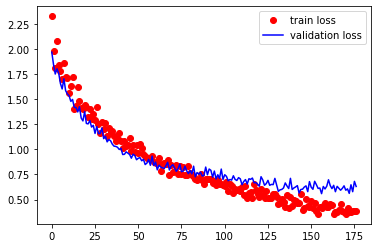

In [29]:
# 모델 확인
import matplotlib.pyplot as plt

train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

plt.plot(train_acc,'bo', color='r', label='accuracy')
plt.plot(val_acc,'b', color='b', label='val accuracy')
plt.legend()
plt.show()


train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss,'bo', color='r', label='train loss')
plt.plot(val_loss,'b', color='b', label='validation loss')
plt.legend()
plt.show()

[ 4. 10.  2.  8.  5.  8.  3.  3.  0.  3.]
[1.7624938e-04 7.3180959e-02 7.4634524e-03 5.2534592e-01 5.6823421e-05
 7.9312874e-03 5.0398009e-03 1.8296210e-02 3.0930528e-01 4.5123640e-02
 8.0803400e-03]
Confusion Matrix
[8 3 8 5 7 3 8 3 9 3]


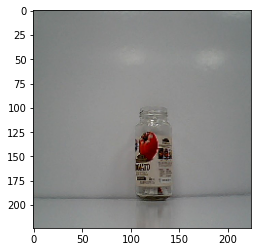

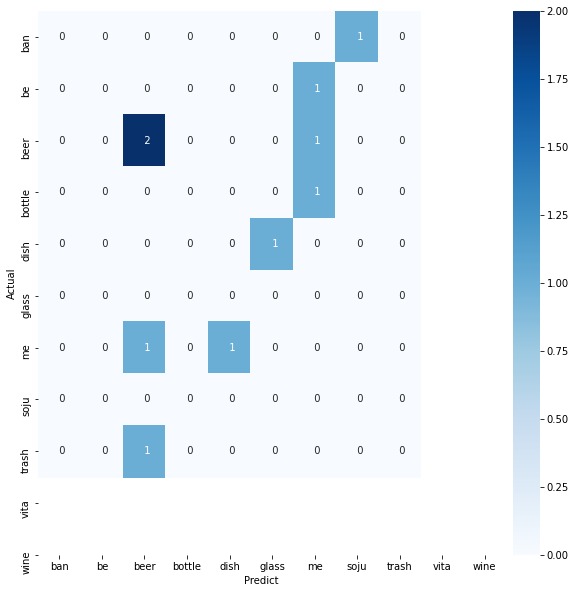

In [37]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns 
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

with tf.device('/device:GPU:0'):


    model_path = '../model/recycle_vgg16_1205.h5'


    vgg_model = tf.keras.models.load_model(model_path)


    x_train, y_train= validationGen.next()
    print(y_train)
    plt.imshow(x_train[5])

    #Confution Matrix and Classification Report
    Y_pred = vgg_model.predict_generator(validationGen, 1)
    
    print(Y_pred[5])

    y_pred = np.argmax(Y_pred, axis=1)


    print('Confusion Matrix')
    # display(confusion_matrix(validationGen.classes, y_pred))

    print(y_pred)





    fig, ax = plt.subplots(figsize=(10,10))  # inch단위로 그림의 크기
    sns.heatmap(
        confusion_matrix(y_train, y_pred),
        annot = True, # 숫자표현
        fmt = '3d',    # 정수표현     
        cmap = 'Blues', # color 색상
        ax = ax,       # 그래프로 사용할 subplot
        xticklabels=category_csv['bottle_name'], 
        yticklabels=category_csv['bottle_name']
    )
    ax.set_xlabel('Predict')
    ax.set_ylabel('Actual')
    plt.show()